In [2]:
from torrequest import TorRequest
import requests
import stem
from bs4 import BeautifulSoup
import json
import pandas as pd
import matplotlib
import time
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


In [3]:
pd.set_option('mode.chained_assignment', None)

In [4]:
tr = TorRequest(password='test12345')
SocksPort = 9052

response = requests.get('http://ipecho.net/plain')
print("My Original IP Address:", response.text)

tr.reset_identity() #Reset Tor
response = tr.get('http://ipecho.net/plain')
print("New Ip Address", response.text)

My Original IP Address: 73.45.64.108
New Ip Address 23.129.64.185


In [92]:
model_dict = {'forester':'21165','outback':'21697', 'sorento':'22084', 'ascent':'36362567'}
make_dict = {'subaru':'20041','kia':'20068'}


In [203]:
carname = 'forester'

In [94]:
base_string = """https://www.cars.com/for-sale/searchresults.action/?dealerType=all&mdId={0}{2}&page={1}&perPage=100&rd=50&sort=relevance&yrId=39723%2C47272%2C51683%2C56007%2C58487%2C30031936%2C35797618%2C36362520%2C36620293&zc=60045"""


In [95]:
third_row = '&normFeatureId=20004525' if carname == 'sorento' else ''

In [96]:
#search_page = 'https://www.cars.com/vehicledetail/detail/{0}/overview/'.format(x)

tr.reset_identity() #Reset Tor
resp = tr.get(base_string.format(model_dict[carname],1,third_row))
#resp = tr.get(base_string.format(model_dict[carname],1,third_row))
soup = BeautifulSoup(resp.content, 'html.parser')

json_result = json.loads(soup.find_all('script')[1].contents[0].split(';\n')[1].split('.digitalData = ')[1])

pages = json_result['page']['search']['totalNumPages']
print('pages: ',pages)

pages:  4


In [97]:
details_resp = []
details = []
detail_features = []
page_dfs = []

detail_cols = ['listingId','isActiveListing','canonicMakeName','trimName','modelPackageName','priceMsrp','priceOld','priceChangeDate','miles','exteriorColor',
                  'engineDescription','listingDateSeconds','drivetrain','oneOwner','sellerAcceptsBestOffer','vehicleHistoryDetails','autoPriceDealLabel','priceBadgeInfo']


for x in range(1,pages+1):
    print('page: ',x)
    if x >1:
        tr.reset_identity()
        resp = tr.get(base_string.format(model_dict[carname],x,third_row))
        soup = BeautifulSoup(resp.content, 'html.parser')
        json_result = json.loads(soup.find_all('script')[1].contents[0].split(';\n')[1].split('.digitalData = ')[1])
        
    # master df of cars on page                  
    cars = json_result['page']['vehicle']
    page_df = pd.DataFrame(cars)
    page_df = pd.concat([page_df.drop(['seller'], axis=1), page_df['seller'].apply(pd.Series)], axis=1)

    drop_cols = ['phoneNumber2','truncatedDescription','privateSeller','customerId','rating','reviewCount','dealerChatProvider','hasCpoShowroomEnabled']

    page_df.drop(drop_cols,axis = 1,inplace = True)
    page_dfs.append(page_df)
                            
    # scrape listings found above and pull extra data
    for x in page_df['listingId'].values.tolist():
        search_page = 'https://www.cars.com/vehicledetail/detail/{0}/overview/'.format(x)
        resp = requests.get(search_page)

        soup = BeautifulSoup(resp.content, 'html.parser')

        car_resp = soup.find_all('script', type="application/json")

        resp_dict = json.loads(car_resp[0].text)['listingDetailDto']
        features = resp_dict['additionalFeatures']
        details_resp.append(resp_dict)
        #del resp_dict['additionalFeatures']
        #del resp_dict['truncatedDescription']


        detail_data =[resp_dict[x] for x in detail_cols]
        details.append(detail_data)

        features = resp_dict['additionalFeatures']
        detail_features.append(features)

        time.sleep(1)
        

page:  1
page:  2
page:  3
page:  4


In [107]:
# build response dfs
df = pd.concat(page_dfs)

detail_df = pd.DataFrame(details,columns = detail_cols)
feature_df = pd.Series(detail_features,index = df['listingId'].values.tolist()).to_frame()
detail_df = pd.concat([detail_df.drop(['priceBadgeInfo'], axis=1), detail_df['priceBadgeInfo'].apply(pd.Series)], axis=1)

out_full = pd.merge(df, detail_df, how = 'left', on = ['listingId'])
out_df = out_full[['listingId','make','model','year','trim','drivetrain','price','mileage','engineDescription','exteriorColor','predictedPriceV1','oneOwner','distanceFromSearchZip']]


feature_melt = pd.DataFrame(detail_features,index = df['listingId'].values.tolist()).reset_index()
feature_melt = pd.melt(feature_melt,id_vars = ['index']).drop(['variable'],axis = 1)
feature_melt['value'] = feature_melt['value'].str.upper().str.replace('[^a-zA-Z0-9 ]', '')
feature_melt = feature_melt.drop_duplicates()
feature_melt['count'] = 1
feature_melt = feature_melt.set_index(['index','value']).unstack('value')
feature_melt.columns = feature_melt.columns.droplevel(0)
feature_melt = feature_melt.fillna(0)
feature_melt.drop([np.nan],axis = 1,inplace = True)
feature_melt = feature_melt.reset_index().rename(columns = {'index':'listingId'})

feature_dict = {'sorento':['listingId','HEATED SEATS','KEYLESS ENTRY','LEATHER SEATS'],
               'ascent':['listingId','HEATED DRIVERS SEAT','HEATED FRONT BUCKET SEATS','HEATED FRONT SEATS']}

out_df = pd.merge(out_df,feature_melt[feature_dict[carname]],how = 'left',
         on = ['listingId'] )

In [206]:
#reset color

color_list = ['blue','green','black','orange','pink','purple','teal','lightgreen','chocolate','navy','crimson','magenta','lime', 'seagreen', 'salmon']
trim_list = out_df['trim'].unique().tolist()

color_dict = dict(zip(trim_list, color_list[0:len(trim_list)]))
    
out_df['color']= out_df['trim'].map(color_dict)
out_df.loc[out_df['color']=='','color'] = 'grey'
out_df.loc[out_df['color'].isnull(),'color'] = 'grey'

# target model

In [108]:
# out_df.to_csv('C:\\Users\\karlm\\PycharmProjects\\car_data\\{0}_out.csv'.format(carname))
# feature_melt.to_csv('C:\\Users\\karlm\\PycharmProjects\\car_data\\{0}_features.csv'.format(carname))

In [204]:
#read in data again
out_df = pd.read_csv('C:\\Users\\karlm\\PycharmProjects\\car_data\\{0}_out.csv'.format(carname))
feature_melt = pd.read_csv('C:\\Users\\karlm\\PycharmProjects\\car_data\\{0}_features.csv'.format(carname))

In [183]:
#sorento changes
out_df = out_df[out_df['drivetrain']=='AWD']

#fix trims
out_df.loc[out_df['trim']=='LX V6','trim'] = 'LX'
out_df.loc[out_df['trim']=='SX V6','trim'] = 'SX'

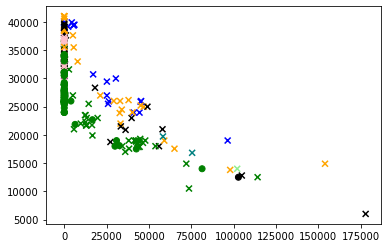

In [185]:
#sorento only
mkr_dict = {'V6': 'x', 'I4': 'o'}

for kind in mkr_dict:
    d = out_df[out_df['engineDescription'].str.contains(kind)]
    plt.scatter(d.mileage, d.price, 
                c = d.color, 
                marker = mkr_dict[kind])
plt.show()

In [218]:
graph_df = out_df[(out_df['year']>=2016) & (out_df['color']=='lightgreen')]

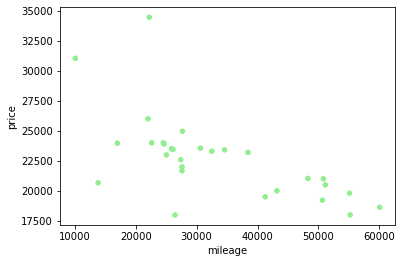

In [219]:
graph_df.plot.scatter(x = 'mileage',y = 'price',c=graph_df['color'])

In [220]:
curr_df = graph_df[(graph_df['price']<=23000) & (graph_df['mileage']<30000) ]

In [217]:
color_dict

{'Sport': 'blue',
 '2.5i': 'green',
 'Touring': 'black',
 '2.5i Touring': 'orange',
 '2.5i Premium': 'pink',
 'Premium': 'purple',
 '2.0XT Touring': 'teal',
 '2.5i Limited': 'lightgreen',
 '2.5X Touring': 'chocolate',
 '2.5X': 'navy',
 '2.5X Premium': 'crimson',
 '2.0XT Premium': 'magenta',
 'Limited': 'lime',
 '2.5X Limited': 'seagreen',
 nan: 'salmon'}

In [221]:
curr_df

,Unnamed: 0,listingId,make,model,year,trim,drivetrain,price,mileage,engineDescription,exteriorColor,predictedPriceV1,oneOwner,distanceFromSearchZip,color,HEATED SEATS,KEYLESS ENTRY,LEATHER SEATS
35,35,793574771,Subaru,Forester,2016,2.5i Limited,AWD,17993.0,26432.0,2.5L H4 16V MPFI DOHC,Venetian Red Pearl,20600.0,False,16,lightgreen,0.0,0.0,0.0
39,39,787351860,Subaru,Forester,2017,2.5i Limited,AWD,21994.0,27578.0,2.5L H4 16V MPFI DOHC,Dark Gray Metallic,22783.0,True,16,lightgreen,0.0,0.0,0.0
51,51,794152254,Subaru,Forester,2017,2.5i Limited,AWD,21669.0,27577.0,2.5L H4 16V MPFI DOHC,Dark Gray Metallic,22801.0,False,20,lightgreen,0.0,0.0,0.0
100,100,793286524,Subaru,Forester,2017,2.5i Limited,AWD,22590.0,27382.0,2.5L,Ice Silver Metallic,23443.0,False,2,lightgreen,0.0,0.0,0.0
268,268,797476507,Subaru,Forester,2017,2.5i Limited,AWD,22991.0,25010.0,2.5L H4 16V MPFI DOHC,Ice Silver Metallic,23443.0,True,16,lightgreen,0.0,0.0,0.0
351,351,797621516,Subaru,Forester,2016,2.5i Limited,AWD,20669.0,13794.0,2.5L H4 16V MPFI DOHC,Venetian Red Pearl,20972.0,False,20,lightgreen,0.0,0.0,1.0
